In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

from cv2 import imread, resize

2021-09-21 15:18:29.642648: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-21 15:18:29.642764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


1. Полносвязные сети (многослойный персептрон)

Решите задачу классификации данных, с которыми вы работали в лабораторной № 2, результат сравните с полученными ранее

In [2]:
data = pd.read_csv('../input/water-quality/waterQuality1.csv')

data = data.drop('ammonia', axis = 1)
data = data.drop('flouride', axis = 1)
data = data.drop('selenium', axis = 1)
data = data.drop('uranium', axis = 1)

data = data[data['is_safe'] != '#NUM!']
data['is_safe'] = data['is_safe'].astype(int)

columns = dict(zip(list(range(data.shape[1])), data.columns.values.tolist()))
is_safe = data['is_safe']

data = pd.DataFrame(StandardScaler().fit_transform(data)).rename(columns = columns)
data['is_safe'] = is_safe
data = data.dropna()
data.head(6)

,aluminium,arsenic,barium,cadmium,chloramine,chromium,copper,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,silver,is_safe
0,0.777403,-0.480875,1.054205,-0.993241,-0.711941,2.152993,-0.973050,-0.363345,-0.869387,-0.781070,1.129767,-0.348629,0.609178,1.203362,1.661842,1.338736,1.0
1,1.306945,-0.599632,1.432447,-1.131948,1.208552,1.598765,-0.223303,1.002460,0.849782,0.009785,-1.409197,1.046960,-0.739005,0.892977,0.124811,0.851134,1.0
2,0.271572,-0.480875,-0.812340,-0.965499,0.803417,1.044536,-1.202564,-0.818614,-0.861452,-0.368450,0.783298,-0.383518,0.272132,1.911763,1.786699,2.035310,0.0
3,0.548198,-0.480875,1.144654,-1.159690,1.968179,-0.802892,1.306793,1.184567,1.008475,-1.434385,-1.517469,-0.069511,-0.401960,-0.415275,-0.516695,2.104968,1.0
4,0.200439,-0.520460,-1.124801,-1.020982,0.191820,1.635713,-0.361012,-0.575804,-0.866742,0.302058,-0.555658,-0.383518,-0.739005,0.024578,-0.219622,-0.611672,1.0
5,0.216246,-0.520460,1.078873,-1.104207,-0.536643,0.675051,0.878366,1.063162,0.902680,0.611523,-0.012496,0.977180,0.272132,0.605207,1.076306,0.293875,1.0


In [3]:
X = data.drop('is_safe', axis = 1)
Y = data['is_safe']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 13)

In [4]:
def build_():
    model = Sequential()
    
    model.add(Dense(256, input_dim = 16))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(2, activation = 'sigmoid'))
    
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'sgd',
        metrics = [keras.metrics.Recall(name = 'recall')]
    )
    return model


class MLP():
    def __init__(self, epochs, batch_size):
        self.clf = KerasClassifier(build_, epochs = epochs, batch_size = batch_size)
        
    def fit_(self, x, y):
        self.clf.fit(x, y, verbose = 0)
    
    def predict_(self, x, y):
        self.p = self.clf.predict(x)
        return np.sum(y == self.p) / len(y)
        
        
clf = MLP(epochs = 250, batch_size = 32)
clf.fit_(X_train, Y_train)

clf.predict_(X_test, Y_test)

2021-09-21 15:18:35.047743: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-21 15:18:35.050666: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-21 15:18:35.050705: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-21 15:18:35.050730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (316637ce2310): /proc/driver/nvidia/version does not exist
2021-09-21 15:18:35.051183: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

0.9173616376042456

2. Сверточные сети 

Решите задачу классификации изображений (если в выбранном датасете много классов, достаточно оставить, например, 5)


In [5]:
path = '../input/flowers-recognition/flowers'
classes = np.array(os.listdir(path))
for i, j in enumerate(classes):
    print(i, j)

0 dandelion
1 daisy
2 sunflower
3 tulip
4 rose


In [6]:
X = []
Y = []

for i, j in enumerate(classes):
    folder = path + '/' + str(j)
    for image in os.listdir(folder):
        img = imread((os.path.join(folder, image)), 1)[...,::-1] / 255.0
        img = resize(img, (100, 100))
        X.append(img)
        Y.append(i)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

X_train = np.array(X_train)
Y_train = to_categorical(np.array(Y_train))
X_test = np.array(X_test)

In [8]:
def build_():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape = (100, 100, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'rmsprop',
            metrics = [keras.metrics.Recall(name = 'recall'), 
                       keras.metrics.Accuracy(name = 'accuracy')]
        )

    return model


class CNN():
    def __init__(self, epochs, batch_size):
        self.clf = KerasClassifier(build_, epochs = epochs, batch_size = batch_size)
        
    def fit_(self, x, y):
        self.clf.fit(x, y, verbose = 0)
    
    def predict_(self, x, y, z):
        self.p = self.clf.predict(x)
        return np.sum(z == self.p) / len(z)
        
        
clf = CNN(epochs = 25, batch_size = 16)
clf.fit_(X_train, Y_train)

clf.predict_(X_test, to_categorical(np.array(Y_test)), Y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.5729166666666666

3. Рекуррентные сети

Решите любую задачу по вашему выбору, обязательным условием является только использование рекуррентной сети (это может быть предсказание значений временного ряда или задача классификации текстов)


In [9]:
df = pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv')
df = df.drop(['Volume', 'Adj Close'], axis = 1)
df.Date = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

df.head(6)

,High,Low,Open,Close
Date,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107
2015-11-28,2093.290039,2084.129883,2088.820068,2090.110107


In [10]:
df.isnull().sum()

High     0
Low      0
Open     0
Close    0
dtype: int64

In [11]:
train_len = round(0.8 * len(df['Close']))
window = 10

train_data = df['Close'][0:train_len]

X_train = []
Y_train = []

for i in range(window, len(train_data)):
    X_train.append(train_data[i - window:i])
    Y_train.append(train_data[i])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

test_data = df['Close'][train_len - window:]

X_test = []
Y_test = [] 

for i in range(window, len(test_data)):
    X_test.append(test_data[i - window:i])
    Y_test.append(test_data[i])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [12]:
model = Sequential()

model.add(LSTM(50, activation = 'relu', input_shape = (X_train.shape[1], 1)))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.fit(X_train, Y_train, epochs = 10, batch_size = 8)

Epoch 1/10
182/182 [==============================] - 2s 5ms/step - loss: 857940.9134
Epoch 2/10
182/182 [==============================] - 1s 5ms/step - loss: 738.6537
Epoch 3/10
182/182 [==============================] - 1s 5ms/step - loss: 720.0946
Epoch 4/10
182/182 [==============================] - 1s 5ms/step - loss: 811.4303
Epoch 5/10
182/182 [==============================] - 1s 5ms/step - loss: 782.8570
Epoch 6/10
182/182 [==============================] - 1s 5ms/step - loss: 785.5980
Epoch 7/10
182/182 [==============================] - 1s 5ms/step - loss: 1160.3222
Epoch 8/10
182/182 [==============================] - 1s 5ms/step - loss: 808.7542
Epoch 9/10
182/182 [==============================] - 1s 6ms/step - loss: 928.1670
Epoch 10/10
182/182 [==============================] - 1s 5ms/step - loss: 925.0773


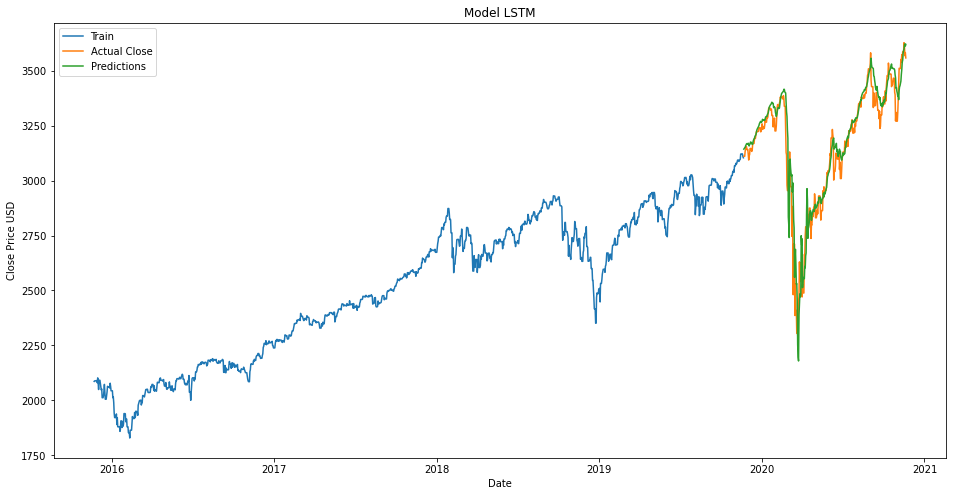

In [13]:
train = df['Close'][:train_len]
test = pd.DataFrame(df['Close'][train_len:])
test['Predictions'] = model.predict(X_test)

plt.figure(figsize = (16, 8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(test[['Close','Predictions']])
plt.legend(['Train','Actual Close','Predictions'])
plt.show()